$by$ XIE Lin

In [1]:
import wrds
db = wrds.Connection()

Enter your WRDS username [linxie]:xielin
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

In [3]:
conn = wrds.Connection()

Enter your WRDS username [linxie]:xielin
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


## COMPUSTAT Part

In [4]:
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """)

#### convert datadate to dates

In [5]:
comp['datadate'] = pd.to_datetime(comp['datadate'])
comp['year'] = comp['datadate'].dt.year

#### preferred stock

In [6]:
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])

In [7]:
comp['ps'] = np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])

In [8]:
comp['ps'] = np.where(comp['ps'].isnull(),0,comp['ps'])

In [9]:
comp['txditc'] = comp['txditc'].fillna(0)

#### book equity

In [10]:
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']

In [11]:
comp['be'] = np.where(comp['be'] > 0, comp['be'], np.nan)

#### number of years in COMPUSTAT

In [12]:
comp = comp.sort_values(by = ['gvkey', 'datadate'])

In [13]:
comp['count'] = comp.groupby(['gvkey']).cumcount()

In [14]:
comp = comp[['gvkey', 'datadate', 'year', 'be', 'count']]

## CRSP Part

In [15]:
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1959' and '12/31/2017'
                      and b.exchcd between 1 and 3
                      """) 

#### change variable into integer format

In [16]:
crsp_m[['permco','permno','shrcd','exchcd']] = crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

#### set the date to be the end-of-month date

In [17]:
crsp_m['date'] = pd.to_datetime(crsp_m['date'])

In [18]:
crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0)

#### delisting return

In [19]:
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)

In [20]:
dlret.permno = dlret.permno.astype(int)

In [21]:
dlret['dlstdt'] = pd.to_datetime(dlret['dlstdt'])

In [22]:
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)

In [23]:
crsp = pd.merge(crsp_m, dlret, how = 'left',on = ['permno','jdate'])

In [24]:
crsp['dlret'] = crsp['dlret'].fillna(0)

In [25]:
crsp['ret'] = crsp['ret'].fillna(0)

In [26]:
crsp['retadj'] = (1+crsp['ret'])*(1+crsp['dlret']) - 1

##### market equity calculation

In [27]:
crsp['me'] = crsp['prc'].abs()*crsp['shrout']

In [28]:
crsp = crsp.drop(['dlret','dlstdt','prc','shrout'], axis = 1)

In [29]:
crsp = crsp.sort_values(by = ['jdate','permco','me'])

### Market Capitalization

In [30]:
crsp_summe = crsp.groupby(['jdate', 'permco'])['me'].sum().reset_index()

In [31]:
crsp_maxme = crsp.groupby(['jdate', 'permco'])['me'].max().reset_index()

In [32]:
crsp1 = pd.merge(crsp, crsp_maxme, how = 'inner', on = ['jdate', 'permco', 'me'])

In [33]:
crsp1 = crsp1.drop(['me'], axis = 1)

In [34]:
crsp2 = pd.merge(crsp1, crsp_summe, how = 'inner', on = ['jdate', 'permco'])

In [35]:
crsp2 = crsp2.sort_values(by = ['permno', 'jdate']).drop_duplicates()

##### December market capitalization

In [36]:
crsp2['year'] = crsp2['jdate'].dt.year

In [37]:
crsp2['month'] = crsp2['jdate'].dt.month

In [38]:
decme = crsp2[crsp2['month'] == 12]

In [39]:
decme = decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### dates from July to June

In [40]:
crsp2['ffdate'] = crsp2['jdate'] + MonthEnd(-6)

In [41]:
crsp2['ffyear'] = crsp2['ffdate'].dt.year

In [42]:
crsp2['ffmonth'] = crsp2['ffdate'].dt.month

In [43]:
crsp2['1 + retx'] = 1 + crsp2['retx']

In [44]:
crsp2 = crsp2.sort_values(by = ['permno', 'date'])

#### cumulative return of each stock

In [45]:
crsp2['cumretx'] = crsp2.groupby(['permno', 'ffyear'])['1 + retx'].cumprod()

#### lag cumulative return of each stock

In [46]:
crsp2['lcumretx'] = crsp2.groupby(['permno'])['cumretx'].shift(1)

#### lag market capitalization

In [47]:
crsp2['lme'] = crsp2.groupby(['permno'])['me'].shift(1)

In [48]:
crsp2['count'] = crsp2.groupby(['permno']).cumcount()

In [49]:
crsp2['lme'] = np.where(crsp2['count'] == 0, crsp2['me']/crsp2['1 + retx'], crsp2['lme'])

#### market capitalization baseline

In [50]:
mebase = crsp2[crsp2['ffmonth'] == 1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

#### merge the above

In [51]:
crsp3 = pd.merge(crsp2, mebase, how = 'left', on = ['permno','ffyear'])

In [52]:
crsp3['wt'] = np.where(crsp3['ffmonth'] == 1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

In [53]:
decme['year'] = decme['year']+1

In [54]:
decme = decme[['permno','year','dec_me']]

#### information in June

In [55]:
crsp3_jun = crsp3[crsp3['month'] == 6]

In [56]:
crsp_jun = pd.merge(crsp3_jun, decme, how = 'inner', on = ['permno','year'])

In [57]:
crsp_jun = crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj',
                   'me','wt','cumretx','mebase','lme','dec_me']]

In [58]:
crsp_jun = crsp_jun.sort_values(by = ['permno','jdate']).drop_duplicates()

## COMPUSTAT and CRSP Merge

In [59]:
ccm = pd.read_csv("E:/PhD Application/Replication/FF1993/CRSP.CCMLINKTABLE.csv") 

In [60]:
ccm['LINKDT'] = pd.to_datetime(ccm['LINKDT'])

In [61]:
ccm['LINKENDDT'] = pd.to_datetime(ccm['LINKENDDT'])

In [62]:
ccm['LINKENDDT'] = ccm['LINKENDDT'].fillna(pd.to_datetime('today'))

In [63]:
ccm['gvkey'] = ccm['gvkey'].astype(int)
comp['gvkey'] = comp['gvkey'].astype(int)

In [64]:
ccm1 = pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how = 'left',on = ['gvkey'])

In [65]:
ccm1['yearend'] = ccm1['datadate'] + YearEnd(0)

In [66]:
ccm1['jdate'] = ccm1['yearend'] + MonthEnd(6)

#### bounds of date linkage

In [67]:
ccm2 = ccm1[(ccm1['jdate'] >= ccm1['LINKDT']) & (ccm1['jdate'] <= ccm1['LINKENDDT'])]

In [68]:
ccm2 = ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

#### combine COMPUSTAT and CRSP

In [69]:
ccm_jun = pd.merge(crsp_jun, ccm2, how = 'inner', on = ['permno', 'jdate'])

In [70]:
ccm_jun['beme'] = ccm_jun['be'] * 1000 / ccm_jun['dec_me']

#### stock selection

In [71]:
nyse = ccm_jun[(ccm_jun['exchcd'] == 1) & (ccm_jun['beme'] > 0) & (ccm_jun['me'] > 0) & (ccm_jun['count'] > 1) 
             & ((ccm_jun['shrcd'] == 10) | (ccm_jun['shrcd'] == 11))]

In [72]:
nyse_sz = nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns = {'me':'sizemedn'})

In [73]:
nyse_bm = nyse.groupby(['jdate'])['beme'].describe(percentiles = [0.3, 0.7]).reset_index()

In [74]:
nyse_bm = nyse_bm[['jdate','30%','70%']].rename(columns = {'30%':'bm30', '70%':'bm70'})

In [75]:
nyse_breaks = pd.merge(nyse_sz, nyse_bm, how = 'inner', on = ['jdate'])

In [76]:
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how = 'left', on = ['jdate'])

#### size and BE/ME assignment

In [77]:
def sz_bucket(row):
    if row['me'] == np.nan:
        value = ''
    elif row['me'] <= row['sizemedn']:
        value = 'S'
    else:
        value = 'B'
    return value

In [78]:
def bm_bucket(row):
    if 0 <= row['beme'] <= row['bm30']:
        value = 'L'
    elif row['beme'] <= row['bm70']:
        value = 'M'
    elif row['beme'] > row['bm70']:
        value = 'H'
    else:
        value = ''
    return value

#### portfolio size

In [79]:
ccm1_jun['szport'] = np.where((ccm1_jun['beme'] > 0) & (ccm1_jun['me'] > 0)
                            & (ccm1_jun['count'] >= 1), ccm1_jun.apply(sz_bucket, axis = 1), '')

#### portfolio BE/ME

In [80]:
ccm1_jun['bmport'] = np.where((ccm1_jun['beme'] > 0) & (ccm1_jun['me'] > 0)
                            & (ccm1_jun['count'] >= 1), ccm1_jun.apply(bm_bucket, axis = 1), '')

In [81]:
ccm1_jun['posbm'] = np.where((ccm1_jun['beme'] > 0) & (ccm1_jun['me'] > 0) & (ccm1_jun['count'] >= 1), 1, 0)

In [82]:
ccm1_jun['nonmissport'] = np.where((ccm1_jun['bmport'] != ''), 1, 0)

#### assignment portfolio to June

In [83]:
june = ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]

In [84]:
pd.options.mode.chained_assignment = None 

In [85]:
june['ffyear'] = june['jdate'].dt.year

#### merge with monthly data

In [86]:
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]

In [87]:
ccm3 = pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how = 'left', on = ['permno','ffyear'])

#### select the data needed

In [88]:
ccm4 = ccm3[(ccm3['wt'] > 0)& (ccm3['posbm'] == 1) & (ccm3['nonmissport'] == 1) & 
          ((ccm3['shrcd'] == 10) | (ccm3['shrcd'] == 11))]

## Fama-French factors

#### value-weighted return

In [89]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [90]:
vwret = ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})

In [91]:
vwret['sbport'] = vwret['szport'] + vwret['bmport']

#### counting firms

In [92]:
vwret_n = ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns = {'retadj':'n_firms'})

In [93]:
vwret_n['sbport'] = vwret_n['szport'] + vwret_n['bmport']

#### reshape the dataframe

In [94]:
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()

In [95]:
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

#### generate SMB

In [96]:
ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3

In [97]:
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3

In [98]:
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']

In [99]:
ff_factors=ff_factors.rename(columns={'jdate':'date'})

#### generate HML

In [100]:
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2

In [101]:
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2

In [102]:
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

#### count firms

In [103]:
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']

In [104]:
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']

In [105]:
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

In [106]:
ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']

In [107]:
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']

In [108]:
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']

In [109]:
ff_nfirms['TOTAL']=ff_nfirms['SMB']

In [110]:
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

## Comparison with Fama and French (1993) result

In [111]:
_ff = conn.get_table(library='ff', table='factors_monthly')

In [112]:
_ff=_ff[['date','smb','hml']]

In [113]:
_ff['date']=_ff['date']+MonthEnd(0)

In [114]:
_ffcomp = pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on=['date'])

In [115]:
_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']

In [116]:
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))

(0.9272135119212468, 1.9941617198928195e-244)
(0.9020438179295884, 2.0933660398809948e-209)


In [117]:
result = [stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']),stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])]
result

[(0.9272135119212468, 1.9941617198928195e-244),
 (0.9020438179295884, 2.0933660398809948e-209)]

In [120]:
from pandas.core.frame import DataFrame

In [122]:
a=DataFrame(result, index=['SMB','HML'], columns=['correlation coefficient','p value'])
a

,correlation coefficient,p value
SMB,0.927214,1.994162e-244
HML,0.902044,2.093366e-209


#### visualization

In [118]:
%matplotlib inline

In [286]:
import matplotlib.pyplot as plt

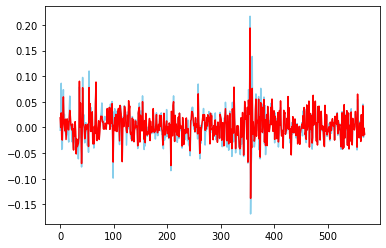

In [289]:
plt.plot(_ffcomp70['smb'], color = 'skyblue')
plt.plot(_ffcomp70['WSMB'], color = 'red')
plt.show()

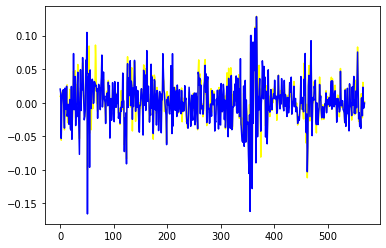

In [292]:
plt.plot(_ffcomp70['hml'], color = 'yellow')
plt.plot(_ffcomp70['WHML'], color = 'blue')
plt.show()

In [125]:
import datetime

(719163.0, 736694.0)

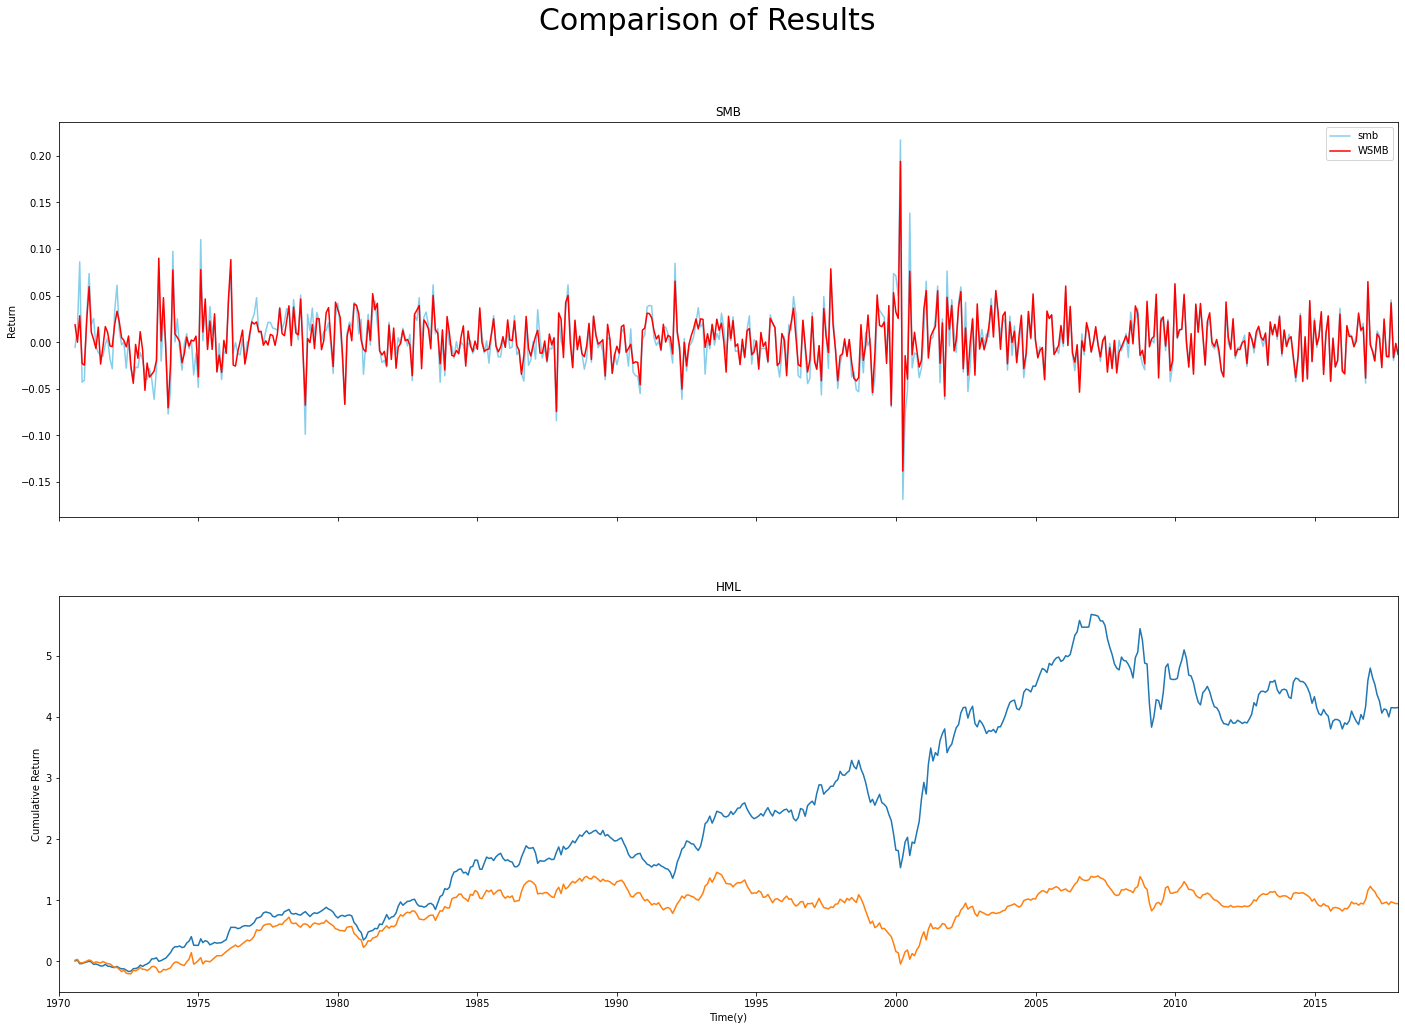

In [140]:
plt.figure(figsize = (24,16)) 
plt.suptitle("Comparison of Results", fontsize = 30)

ax1 = plt.subplot(2, 1, 1)
plt.ylabel("Return")
plt.title("SMB")
plt.plot(_ffcomp70['date'],_ffcomp70['smb'],label = 'smb',color = 'skyblue')
plt.plot(_ffcomp70['date'],_ffcomp70['WSMB'], label = 'WSMB',color = 'red')
plt.legend(loc = "best")
ax1.set_xlim([datetime.date(1970, 1, 1), datetime.date(2017, 12, 31)])
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = plt.subplot(2, 1, 2)
_ffcomp60hml = _ffcomp[['date','hml','WHML']]
_ffcomp60hml.set_index(["date"], inplace = True)
plt.xlabel('Time(y)')
plt.ylabel("Cumulative Return")
plt.title("HML")
#plt.legend(loc="best")
plt.plot((_ffcomp60hml + 1).cumprod() - 1) 
ax2.set_xlim([datetime.date(1970, 1, 1), datetime.date(2017, 12, 31)])